# Core Gaussian Mixture Model

Here we implement a Gaussian Mixture Model to illustrate how to use Jax. In a followup tutorial, we will cover how to use further concepts like `rng` to ensure reproducible runs, and `pmap` for parallelism across devices.

We make use of the following concepts:

- `jit`: to accelerate our code. See [exe_02_jit](../../exercises/exe_02_jit.ipynb) and [Jax jit docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html) for more information
- `vmap`: to automatically vectorize our `e_step` and `m_step` across the matrices of data. See [exe_04_vmap](../../exercises/exe_04_vmap.ipynb) and [jax vmap docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) for more information
- composing `jit` and `vmap`. The functional programming nature of `jax` means that we can compose these higher-order functions, making our code look very clean. See the `e_step` to see this in action.


In [1]:
import jax.numpy as jnp
import jax
from jax.scipy.stats.norm import pdf as n_pdf
import numpy as np  
np.random.seed(123)

from sklearn.datasets import make_blobs

# Problem Setup

Say we are trying to model a simple problem where we have 105 points that are 2-d. We know that there are roughly 4 clusters* and we know more-or-less where they start. However, we want to learn the parameters to fit them.

*In the next notebook we do not assume that we have this prior knowledge

In [2]:
unknown_centers = np.asarray([
    [1, -1],  # bottom left
    [5, 5],  # middle
    [8, 7],  # mid-right
    [10, 0]  # bottom right
])

def make_ds(centers):
    points_in_classes = [30, 50, 20, 5]
    ################################################
    # Initial Guesses
    ################################################
    # Randomly increase/ decrease by 15% each way
    scale = (np.random.randint(low=0, high=30, size=centers.shape) - 15) / 100

    initial_mu_guesses = centers + (centers * scale)
    return make_blobs(points_in_classes, centers=centers), initial_mu_guesses

(X, y), mus = make_ds(unknown_centers)

N, M = X.shape
K = len(np.unique(y))

# Reporting Functions

The following is an implementation of the [Multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution), which we use to enumerate how well our parameters have fit the data. Other implementations of `gaussian_pdf` might
include a `einsum`, or a `vmap`, but we only use the `jit`. 

![](assets/gaussian_pdf.png)

Note how the expression in the `exp(...)` has been implemented as `-0.5 * jnp.sum(diff @ inv * diff, axis=1)`, which looks vastly different from the formula. Further below, in the `_loglikelihood_gaussian` function we see how we can avoid this by mapping
our function over the entire array (without sacrificing speed!) If this isn't clear to you, please read through [exe_02_jit](../../exercises/exe_02_jit.ipynb) and [exe_05_profiling](../../exercises/exe_05_profiling.ipynb) to see this in action, and to see the timings

In [3]:
@jax.jit
def gaussian_pdf(coor: jnp.array, mu_k: jnp.array, sigma_k: jnp.array) -> jnp.array:
    k = len(mu_k)
    t1 = (2 * jnp.pi) ** (-k / 2)
    t2 = jnp.linalg.det(sigma_k) ** (-0.5)

    inv = jnp.linalg.inv(sigma_k)
    diff = coor - mu_k
    to_exp = -0.5 * jnp.sum(diff @ inv * diff, axis=1)

    to_ret = t1 * t2 * jnp.exp(to_exp)

    assert len(to_ret) == len(coor)
    return to_ret

def log_likelihood(data, mu, sigma, pi, K):
    log_likelihood = 0
    for data_point in data:
        mixture_likelihood = 0
        for k in range(K):
            v = pi[k] * gaussian_pdf(
                jnp.expand_dims(data_point, axis=0), mu_k=mu[k], sigma_k=sigma[k]
            )
            mixture_likelihood += v
        log_likelihood += np.log(mixture_likelihood)

    return log_likelihood


# 1) Expectation step: `e_step` 

![](./assets/e_step.png)

**Note** the image above was taken (with permission) from [Prof. Matt Golub](https://homes.cs.washington.edu/~mgolub/)'s course, [Machine Learning for Neuroscience (CSE599N)](https://courses.cs.washington.edu/courses/cse599n/24sp/).

## The E-step comprises two sub-functions:

1) the log-likelihood of the data over the parameters, 
2) the "normalizer" for the [log-sum-exp](https://en.wikipedia.org/wiki/LogSumExp) trick. 


### Log-likelihood Gaussian

This is a log-likelihood calculation that operates on a single row of x, hence the $x_i$ notation. Because we have formulated it this way, we see that our code from before (after applying the log) has become `0.5 * diff @ sigma_inv @ diff`. What's nice
about this is that it makes the equation look closer to the underlying math than whatever tricks we had to pull off earlier

In [4]:

@jax.jit
def _loglikelihood_gaussian(x_i: jnp.array, cls_prior_k: jnp.array, mu_k: jnp.array, sigma_k: jnp.array) -> jnp.array:
    """
    Calculate the LL for a single point
    Args:
        x_i: vector of shape (1, num_feats)
        mu_k: vector of shape (1, num_feats)
        sigma_k: matrix of shape (num_feats, num_feats)

    """
    k = len(mu_k)
    sigma_inv = jnp.linalg.inv(sigma_k)
    sigma_det = jnp.linalg.det(sigma_k)
    log_det_sigma = jnp.log(sigma_det)

    diff = x_i - mu_k
    t1 = -0.5 * k * jnp.log(2 * jnp.pi)
    t2 = -0.5 * log_det_sigma
    t3 = -0.5 * diff @ sigma_inv @ diff

    return t1 + t2 + t3 + jnp.log(cls_prior_k)


## e_step

The `e_step` function composes two `vmap` applications, one after the other. The first one, 

```python
_ll_gaussian_over_rows_given_parameters = jax.vmap(
    fun=_loglikelihood_gaussian,
    in_axes=(0, None, None, None)
)
```

applies the `_loglikelihood_gaussian` function over the 0th axis of the first argument, in this case, our `X` data. As the name suggests, this function assumes that we are already "given" the parameters. Let's do that now.

```python
ll_gaussian_over_parameters = jax.vmap(
    _ll_gaussian_over_rows_given_parameters,
    in_axes=(None, 0, 0, 0)
)
```

Here we map the `_ll_gaussian_over_rows_given_parameters` over the 0th axis of the last 3 arguments **simultaneously**, which means that the 0th axis of those arguments must have the same length.

- `calculate_normalizer`: no special tricks here, just calculating the normalizer for the


In [5]:

@jax.jit
def e_step(X, mus, sigmas, cls_priors):
    """
    X: (N, M)
    mus: (K, M)
    sigmas: (K, M, M)
    cls_priors: (K, M)
    """
    _ll_gaussian_over_rows_given_parameters = jax.vmap(
        fun=_loglikelihood_gaussian,
        in_axes=(0, None, None, None)
    )
    ll_gaussian_over_parameters = jax.vmap(
        _ll_gaussian_over_rows_given_parameters,
        in_axes=(None, 0, 0, 0)
    )
    _responsibilities = ll_gaussian_over_parameters(X, cls_priors, mus, sigmas)
    normalizer = calculate_normalizer(_responsibilities)
    return jnp.exp(_responsibilities - normalizer).T[-1]


@jax.jit
def calculate_normalizer(log_prob_arr: jnp.ndarray) -> jnp.ndarray:
    _max = jnp.max(log_prob_arr, axis=0)
    return _max + jnp.log(jnp.sum(
        jnp.exp(log_prob_arr - _max),
        axis=0
    ))



# 2) Maximization-step `m_step`

![](./assets/m_step.png)

**Note** the image above was taken (with permission) from [Prof. Matt Golub](https://homes.cs.washington.edu/~mgolub/)'s course, [Machine Learning for Neuroscience (CSE599N)](https://courses.cs.washington.edu/courses/cse599n/24sp/).

## The M-step comprises two sub-functions:

1) calculating the parameter update (within the for-loop)
2) calculating the mean
3) the top-level caller

___

In `_m_step_single`, we calculate the mu and sigma for a single row, which we will sum up later. We only need to do this for the `mu` and `sigma` update

In `_m_step` we are given the class specific parameters for class k (`responsibility` and `mu`). We use these parameters to calculate the updated `mu`, `sigma`, and class prior. Our `X` if of shape (N, M) and our `resp_k` is of shape (N, 1), so we map over the 0-th axis of both of them at the same time.

`m_step`: we map our `_m_step`, that is conditioned on the class parameters, across the different class parameters. The `responsibilities` are of shape (N, K) and our `mus` are of shape (K, D), so when we do the `vmap`, we map 
over the 0-th axis of `mu` and the 1st axis of `responsibilities`

In [6]:

@jax.jit
def _m_step_single(x_i, mu_k, resp_nk):
    """
    Calculate the individual values for mu and sigma
    """

    mu_new = x_i * resp_nk
    diff = x_i - mu_k
    sigma_new = resp_nk * jnp.outer(diff, diff)
    return mu_new, sigma_new

@jax.jit
def _m_step(X, mu_k, resp_k):
    N_k = jnp.sum(resp_k)
    to_ave_mus, to_ave_sigmas = jax.vmap(
        _m_step_single,
        in_axes=(0, None, 0)
    )(X, mu_k, resp_k)

    mus = jnp.sum(to_ave_mus, axis=0) / N_k
    sigmas = jnp.sum(to_ave_sigmas, axis=0) / N_k
    cls_prior = N_k / len(X)
    return mus, sigmas, cls_prior

@jax.jit
def m_step(X, mus, responsibilities):
    mus, sigmas, cls_prior = jax.vmap(
        _m_step,
        in_axes=(None, 0, 1)
    )(X, mus, responsibilities)

    return mus, sigmas, jnp.expand_dims(cls_prior, -1)

# Putting it all together

In [7]:
def EM_GMM(
        data: np.ndarray,
        guess_num_classes,
        # Initial guesses
        mus, sigmas, cls_probs,
        
        verbose=False
        
):
    counter = 0
    ll_container = []
    TOL = 0.00001
    ll_container.append(np.inf)

    while True:  # Run until converges
        # e-step
        responsibilities = e_step(data, mus, sigmas, cls_probs)

        # m-step
        mus, sigmas, cls_probs = m_step(data, mus, responsibilities)
        # Recalculate the log-likelihood
        ll_curr = float(log_likelihood(data, mus, sigmas, cls_probs, guess_num_classes))

        if np.abs(ll_container[-1] - ll_curr) < TOL:
            print(f"Converged to within {TOL} after: {counter} iterations")
            break

        ll_container.append(float(ll_curr))
        if verbose:
            print(f"Data Log-Likelihood at iteration: {counter} = {ll_curr:.6f}")
        counter += 1

    responsibilities = e_step(data, mus, sigmas, cls_probs)
    return mus, sigmas, cls_probs.T, responsibilities.T, ll_container[1:]
    # -------------------------- #



# Modeling

In [8]:
# We simply say the covariance for each cluster is the covariance of the entire structure
sigmas = np.asarray([np.cov(X.T) for _ in range(K)])

# We simply 
cls_probs = np.expand_dims(
    np.asarray([1 / K for _ in range(K)]).T,
    axis=-1
)
mus, sigmas, cls_priors, _, lls = EM_GMM(
    X,
    mus=mus,
    sigmas=sigmas,
    cls_probs=cls_probs,
    guess_num_classes=K,
    verbose=True
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/tmp/ipykernel_770007/3994939515.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ll_curr = float(log_likelihood(data, mus, sigmas, cls_probs, guess_num_classes))


Data Log-Likelihood at iteration: 0 = -443.988342
Data Log-Likelihood at iteration: 1 = -431.863617
Data Log-Likelihood at iteration: 2 = -423.096375
Data Log-Likelihood at iteration: 3 = -414.659485
Data Log-Likelihood at iteration: 4 = -411.469940
Data Log-Likelihood at iteration: 5 = -411.281433
Data Log-Likelihood at iteration: 6 = -411.174561
Data Log-Likelihood at iteration: 7 = -411.055695
Data Log-Likelihood at iteration: 8 = -410.898712
Data Log-Likelihood at iteration: 9 = -410.673401
Data Log-Likelihood at iteration: 10 = -410.330536
Data Log-Likelihood at iteration: 11 = -409.787537
Data Log-Likelihood at iteration: 12 = -408.923431
Data Log-Likelihood at iteration: 13 = -407.661713
Data Log-Likelihood at iteration: 14 = -406.240082
Data Log-Likelihood at iteration: 15 = -405.184296
Data Log-Likelihood at iteration: 16 = -404.615997
Data Log-Likelihood at iteration: 17 = -404.323517
Data Log-Likelihood at iteration: 18 = -404.165649
Data Log-Likelihood at iteration: 19 = -4

# Result Investigation

In [9]:
import matplotlib.pyplot as plt

## Plot the Log-likelihood

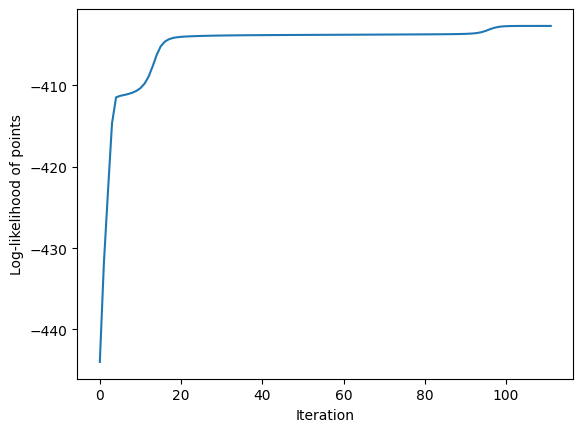

In [10]:
plt.plot(lls)
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood of points")
plt.show()

# Show the Points

In [11]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(mu, sigma, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Modified based on function from: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    pearson = sigma[0, 1]/np.sqrt(sigma[0, 0] * sigma[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(sigma[0, 0]) * n_std
    # calculating the standard deviation of y ...
    scale_y = np.sqrt(sigma[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mu[0], mu[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

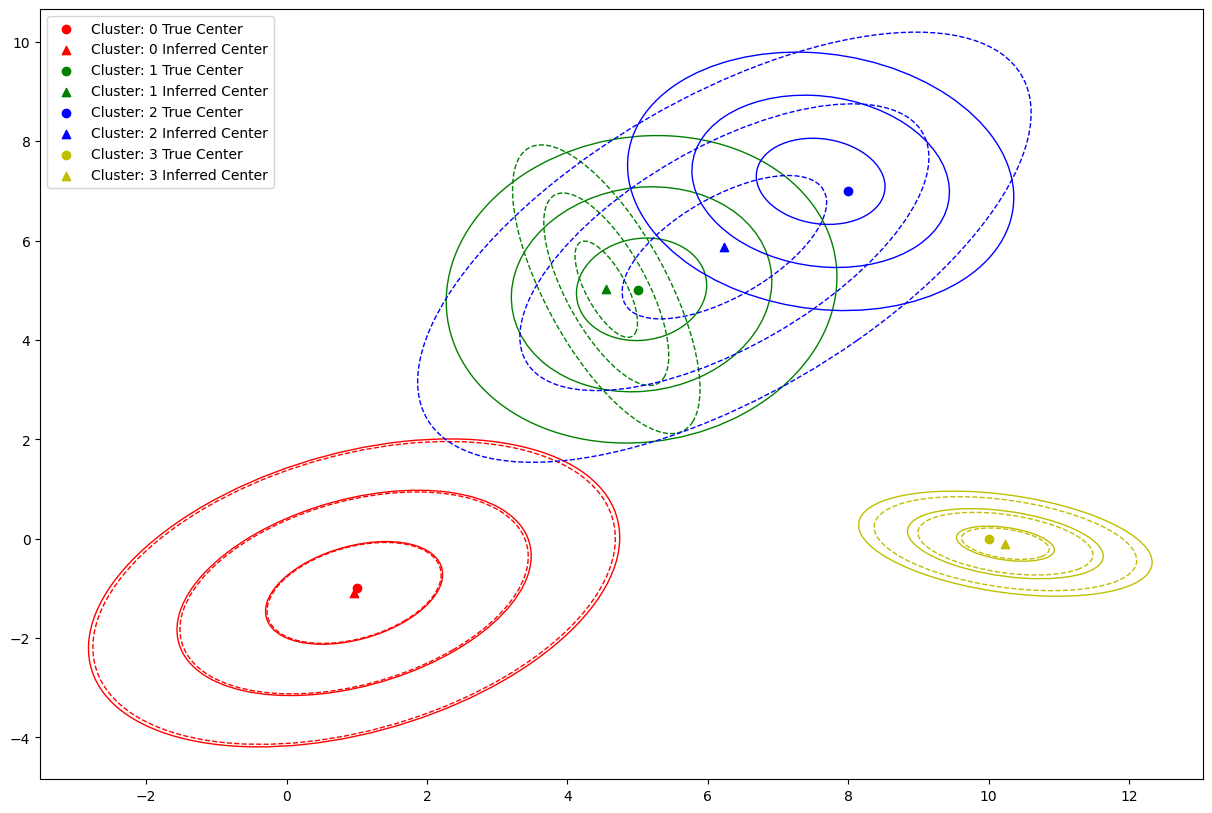

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))

colors = ["r", "g", "b", "y"]

for i, c in enumerate(colors):
    
    # Plot the centers
    plt.scatter(unknown_centers[i, 0], unknown_centers[i, 1], c=c, marker="o", label=f"Cluster: {i} True Center")
    plt.scatter(mus[i, 0], mus[i, 1], c=c, marker="^", label=f"Cluster: {i} Inferred Center")
    
    # Plot the standard deviations
    mask = y == i
    masked_points = X[mask]
    mu_x = np.mean(masked_points, axis=0)
    sigma = np.cov(masked_points[:, 0], masked_points[:, 1])
    confidence_ellipse(mu_x, sigma,  ax=axs, n_std=1, edgecolor=c, linestyle="-")
    confidence_ellipse(mu_x, sigma, ax=axs, n_std=2, edgecolor=c, linestyle="-")
    confidence_ellipse(mu_x, sigma, ax=axs, n_std=3, edgecolor=c, linestyle="-")


    confidence_ellipse(mus[i], sigmas[i],  ax=axs, n_std=1, edgecolor=c, linestyle="--")
    confidence_ellipse(mus[i], sigmas[i], ax=axs, n_std=2, edgecolor=c, linestyle="--")
    confidence_ellipse(mus[i], sigmas[i], ax=axs, n_std=3, edgecolor=c, linestyle="--")
plt.legend(loc="best")


# Followup

Check out [advanced Jax](./additional_jax_gaussian_mixture_model.ipynb) to see Jax's `rng` and `pmap` in action